In [130]:
import pathlib
import os
import datetime
import time

import numpy as np
# import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, Model, utils, optimizers, losses
import tensorflow as tf
import matplotlib.pyplot as plt


In [131]:
# model expected shape=(None, 224, 224)
IMG_SIZE = (224, 224)
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)
flowers_dir = 'small_flower_dataset/'
EPOCHS = 20

In [161]:

batch_size = 32
train_ds = tf.keras.utils.image_dataset_from_directory(
                flowers_dir,
                labels='inferred',
                label_mode='int',
                class_names=None,
                color_mode='rgb',
                batch_size=batch_size,
                image_size=IMG_SIZE,
                shuffle=True,
                seed=2,
                validation_split=0.3,
                subset="training",
                interpolation='bilinear',
                follow_links=False,
                crop_to_aspect_ratio=False)
val_ds = tf.keras.utils.image_dataset_from_directory(
                flowers_dir,
                labels='inferred',
                label_mode='int',
                class_names=None,
                color_mode='rgb',
                batch_size=batch_size,
                image_size=IMG_SIZE,
                shuffle=True,
                seed=2,
                validation_split=0.3,
                subset="validation",
                interpolation='bilinear',
                follow_links=False,
                crop_to_aspect_ratio=False)
class_names = train_ds.class_names

testing_ds = val_ds.take(5)
val_ds = val_ds.skip(5)

print(f"Train ds length: {len(train_ds)} batches")
print(f"Test ds length: {len(testing_ds)} bacthes")
print(f"Val length: {len(val_ds)} batches ")
    

# Configure dataset for performance
AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
testing_ds = testing_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Standardize the data
# The RGB channel values are in the [0, 255] range. 
# This is not ideal for a neural network; in general you should seek to make your input values small.
normalization_layer = layers.Rescaling(1./255)
normalized_train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
normalized_testing_ds = testing_ds.map(lambda x, y: (normalization_layer(x), y))

train_ds = normalized_train_ds
val_ds = normalized_val_ds
testing_ds = normalized_testing_ds

Found 1000 files belonging to 5 classes.
Using 700 files for training.
Found 1000 files belonging to 5 classes.
Using 300 files for validation.
Train ds length: 22 batches
Test ds length: 5 bacthes
Val length: 5 batches 


In [162]:
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
    
# Freeze layer exclude new layer
for layer in base_model.layers:
    layer.trainable=False



In [163]:
# base_model.summary()

In [164]:
feature_extractor = Model(inputs=base_model.inputs, outputs=base_model.output)
# feature_extractor.summary()

#feature extraction
train_activations = feature_extractor.predict(train_ds)
val_activations = feature_extractor.predict(val_ds)
test_activations = feature_extractor.predict(testing_ds)

5/5 [==============================] - 1s 56ms/step


In [165]:
print(train_activations.shape)
print(val_activations.shape)
print(test_activations.shape)

(700, 7, 7, 1280)
(140, 7, 7, 1280)
(160, 7, 7, 1280)


In [166]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
train_x_avg = global_average_layer(train_activations)
val_x_avg = global_average_layer(val_activations)
test_x_avg = global_average_layer(test_activations)

print(train_x_avg.shape)
print(val_x_avg.shape)
print(test_x_avg.shape)

(700, 1280)
(140, 1280)
(160, 1280)


In [167]:
feature_extractor.summary()

Model: "model_35"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_14[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                          

In [168]:
# extract the labels from the _ds batches and concatenate them into one array
train_labels = np.concatenate([y for x, y in train_ds], axis=0)
val_labels = np.concatenate([y for x, y in val_ds], axis=0)
test_labels = np.concatenate([y for x, y in testing_ds], axis=0)

In [169]:
print(val_labels)

[4 2 2 3 2 2 0 0 4 3 4 1 3 2 0 0 4 3 0 1 2 0 1 0 4 3 2 4 1 4 1 2 2 3 2 1 4
 3 0 2 2 4 3 4 4 3 3 3 2 1 1 0 3 3 3 4 0 4 4 4 1 0 3 1 1 0 3 1 3 0 0 1 3 1
 3 2 3 4 1 2 1 4 2 4 0 3 4 2 0 0 3 3 3 3 1 0 4 1 2 1 3 3 1 0 0 0 0 0 2 2 0
 1 2 3 0 0 2 0 4 3 1 3 2 1 4 2 4 3 0 0 2 4 2 1 4 4 1 3 0 2]


In [170]:
inputs = tf.keras.Input(shape=(1280), name="Extracted Features")
# x = layers.GlobalAveragePooling2D(inputs)
x = layers.Dense(256, activation='relu')(inputs)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(5, activation='softmax', name="Classifier")(x)

model = Model(inputs = inputs, outputs = outputs)

model.summary()

model.compile(
    optimizer=optimizers.SGD(learning_rate=0.01, momentum=0, nesterov=False),
    loss=losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"])
    
history = model.fit(x=train_x_avg, y=train_labels, epochs=EPOCHS, validation_data=(val_x_avg, val_labels))



Model: "model_36"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Extracted Features (InputLa  [(None, 1280)]           0         
 yer)                                                            
                                                                 
 dense_21 (Dense)            (None, 256)               327936    
                                                                 
 dropout_21 (Dropout)        (None, 256)               0         
                                                                 
 Classifier (Dense)          (None, 5)                 1285      
                                                                 
Total params: 329,221
Trainable params: 329,221
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
22/22 [==============================] - 1s 12ms/step - loss: 1.8468 - accuracy: 0.1871 - val_loss: 1.7342 

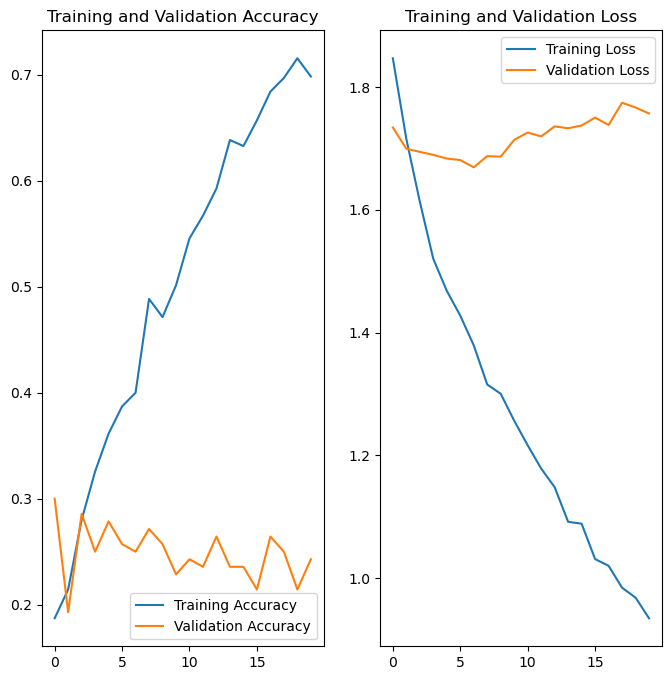

In [171]:
loss = history.history['loss']
val_loss = history.history['val_loss']

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']


epochs_range = range(EPOCHS)
# plt.figure(figsize=(8, 8))



plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')



plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Normal Transfer Learning